In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import curvedsky as cs
import binning
from tqdm import tqdm

In [3]:
sys.path.append('../')

In [4]:
%load_ext autoreload
%autoreload 2
from lbxs4.cmb import CMBLensed
from lbxs4.simulations import LBSky,S4Sky
from lbxs4.filtering import FiltCoadd
from lbxs4.multitracer import CoaddKappa
from lbxs4.delensing import Delenser
from lbxs4.config import *

In [5]:
cmb = CMBLensed()

In [6]:
lb_sky = LBSky(512)
s4_sky = S4Sky()

In [7]:
mask = lb_sky.mask*hp.ud_grade(s4_sky.mask,512)

In [8]:
def inputEB(i):
    teb_input = cmb.TEB(i)
    TQU = hp.alm2map(teb_input,512)/2.726e6 * mask
    Ein,Bin = cs.utils.hp_map2alm_spin(512,1024,1024, 2, TQU[1], TQU[2])
    return Ein,Bin

In [9]:
Ein,Bin = inputEB(0)

In [10]:
dire = '/pscratch/sd/l/lonappan/LBxS4v1'

In [11]:
filts4 = FiltCoadd(dire,s4lib=s4_sky)
filtlb = FiltCoadd(dire,lblib=lb_sky)

INFO:CMB-S4 simulation library is loaded
INFO:LiteBIRD simulation library is loaded


In [55]:
BIn = filtlb.filtBmode(0)[:Bin.shape[0],:Bin.shape[1]]

In [12]:
mask_karg = {'lb_mask':lb_sky.mask,'s4_mask':s4_sky.mask}
kappa  = CoaddKappa(dire,2,1024,512,**mask_karg)

../lbxs4/utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  cls[k][ell[idc]] = cols[i + 1][idc] / we[idc]
../lbxs4/multitracer.py:257: RuntimeWarning: divide by zero encountered in true_divide
  self.INls = np.array( [ 1./self.cov_n[:,:,l].diagonal() for l in range(lmax+1) ] ).T


In [13]:
delenss4 = Delenser(dire,filts4,kappa,)
delenslb = Delenser(dire,filtlb,kappa,)

In [18]:
lensBs4 = delenss4.lensing_B(0)


Reconstructed S4 kappa maps are used


In [19]:
lensBlb = delenslb.lensing_B(0)

Reconstructed S4 kappa maps are used


In [20]:
cmask = lb_sky.mask*hp.ud_grade(s4_sky.mask,512)

In [21]:
cmask = cmask.astype('int')

In [22]:
tempB_my = cs.utils.hp_alm2map(512,1024,1024,lensBlb)
inpB_my = cs.utils.hp_alm2map(512,1024,1024,Bin)
tempB_masked = hp.ma(tempB_my*cmask)
inpB_masked = hp.ma(inpB_my*cmask)
tempB_masked.mask = np.logical_not(cmask)
inpB_masked.mask = np.logical_not(cmask)
tempB_masked = tempB_masked.filled()
inpB_masked = inpB_masked.filled()

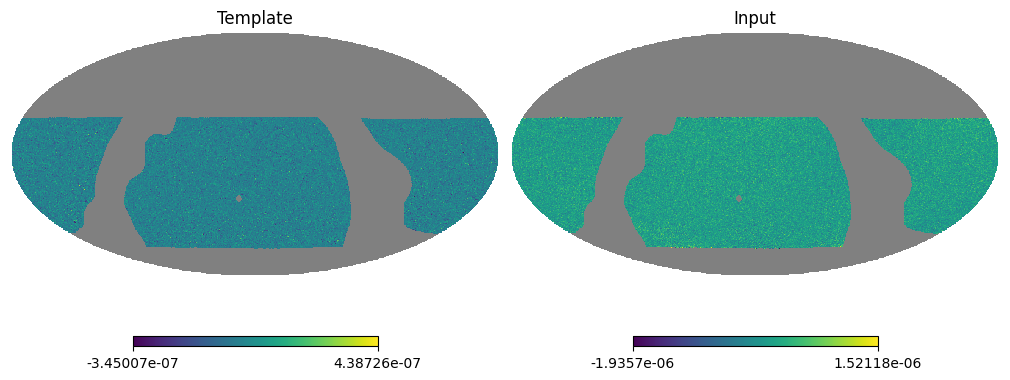

In [23]:
plt.figure(figsize=(10,12))
hp.mollview(tempB_masked,sub=(1,2,1),title='Template')
hp.mollview(inpB_masked,sub=(1,2,2),title='Input')
plt.savefig('Bmode.pdf',dpi=300,bbox_inches='tight')

In [26]:
def rho(lensB,Bin):
    b1 = cs.utils.alm2cl(1024,lensB)
    b2 = cs.utils.alm2cl(1024,Bin)
    b12 = cs.utils.alm2cl(1024,lensB,Bin)
    return b12/np.sqrt(b1*b2)

def rho_arr(delensobj,no=20):
    r = []
    for i in tqdm(range(no)):
        _,Bin = inputEB(i)
        lensB = delensobj.lensing_B(i)
        r.append(rho(lensB,Bin))
    return np.array(r)

In [60]:
rho_lb = rho(lensBlb,BIn)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [61]:
rho_s4 = rho(lensBs4,BIn)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [62]:
rho_s4

array([        nan,         nan, -0.42773549, ..., -0.00283496,
        0.00766376, -0.01410553])

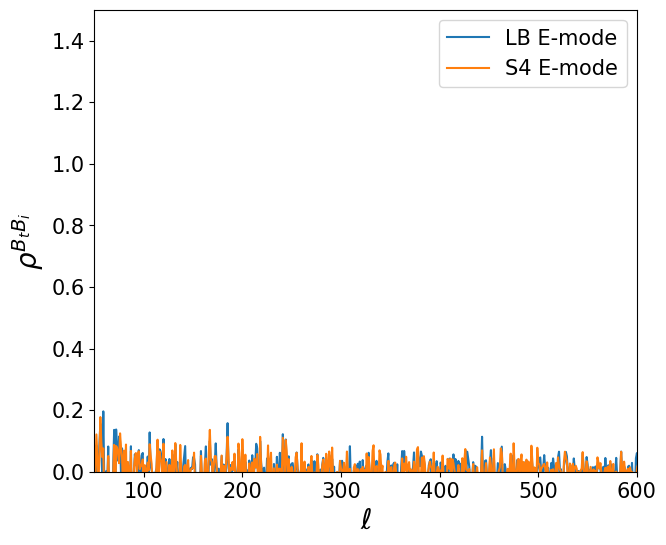

In [63]:

l = np.arange(len(rho_lb))
plt.figure(figsize=(7,6))
plt.plot(l,rho_lb,label='LB E-mode')
#plt.fill_between(l,meanlb-siglb,meanlb+siglb,alpha=0.3)
plt.plot(l,rho_s4,label='S4 E-mode')
#plt.fill_between(l,means4-sigs4,means4+sigs4,alpha=0.3)
plt.xlim(50,600)
plt.ylim(0,1.5)
plt.legend(fontsize=15)
plt.xlabel('$\ell$',fontsize=20)
plt.ylabel('$\\rho^{B_tB_i}$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('rho.pdf',bbox_inches='tight',dpi=300)
